In [1]:
import pandas as pd
import re, string, unicodedata
import nltk
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb

In [2]:
#Loading the data
df_data = pd.read_csv('C:\Sujata\CompScience\Winter 2021\Data Mining\Project Final\mbti_1\mbti_1.csv')

# Removed |||
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_data.head(10)

c:\users\madhu\appdata\local\programs\python\python37\lib\site-packages\pandas\core\dtypes\inference.py:178: FutureWarning: Possible set union at position 2
  re.compile(obj)


,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw h...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired. That's another silly misconce...
5,INTJ,'18/37 @.@ Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,https://www.youtube.com/watch?v=w8-egj0y8Qs ...


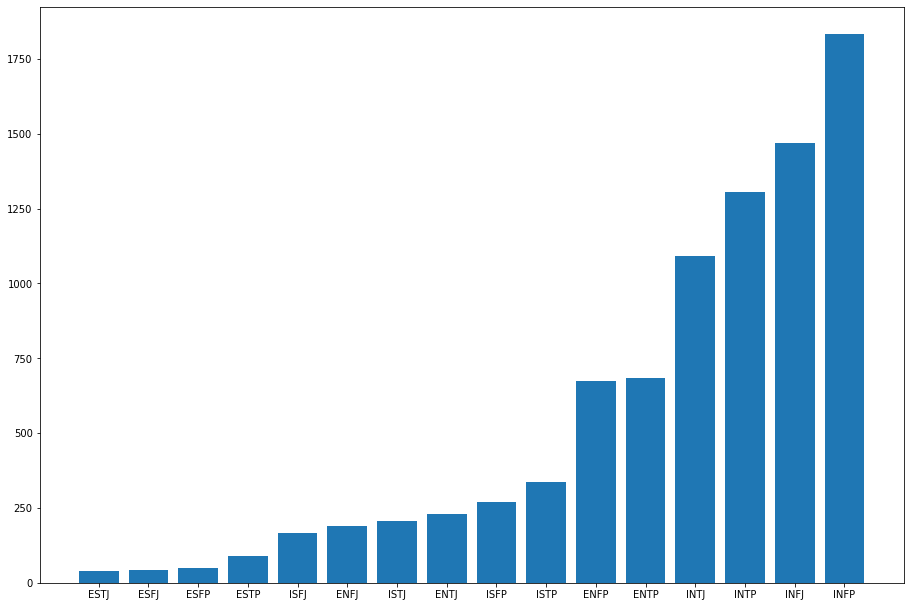

In [3]:
#Data is not balanced
def count_class(DataFrame,count = False ,plot = False):
    # considering 1st Column is for classes 
    Classes = list(df_data[df_data.columns[0]].unique())
    #print(Classes)
    if plot or count:
        count_type = df_data.groupby('type').count()
    #if count : print(count_type)
    if plot:
        fig = plt.figure()
        ax = fig.add_axes([0,0,2,2])
        count_type_temp = count_type.sort_values('posts')
        ax.bar(count_type_temp.index,count_type_temp['posts'])
        plt.show()
    return Classes

classes = count_class(df_data,True,True)

In [4]:
#Diving the 16 MBTI type to only 4
df_data['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_data['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_data['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_data['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_data

,type,posts,is_E,is_S,is_T,is_J
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0,0,0,1
1,ENTP,I'm finding the lack of me in these posts very...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,0


In [5]:
#dropping the type column
df_data = df_data.drop(['type'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0,0,0,1
1,I'm finding the lack of me in these posts very...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [6]:
#Separating the data according to I/E , N/S, F/T AND P/J. All of them has the post column
df_data_IE = df_data.drop(['is_S', 'is_T', 'is_J'], axis=1)
df_data_NS = df_data.drop(['is_E', 'is_T', 'is_J'], axis=1)
df_data_FT = df_data.drop(['is_S', 'is_E', 'is_J'], axis=1)
df_data_PJ = df_data.drop(['is_S', 'is_T', 'is_E'], axis=1)

df_data_IE.head()

,posts,is_E
0,http://www.youtube.com/watch?v=qsXHcwe3krw h...,0
1,I'm finding the lack of me in these posts very...,1
2,'Good one _____ https://www.youtube.com/wat...,0
3,"'Dear INTP, I enjoyed our conversation the o...",0
4,'You're fired. That's another silly misconce...,1


6676
1999


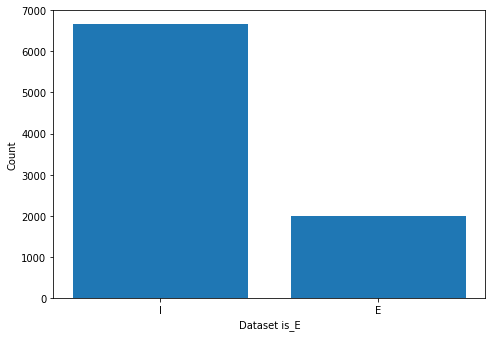

In [7]:
#After spliiting the personaliy type showing the data is still unbalanced for I/E and N/S
I, E = df_data_IE['is_E'].value_counts()
print(I)
print(E)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
personality = ['I', 'E']
count = [I, E]
ax.bar(personality,count)
ax.set_xlabel('Dataset is_E')
ax.set_ylabel('Count')
plt.show()

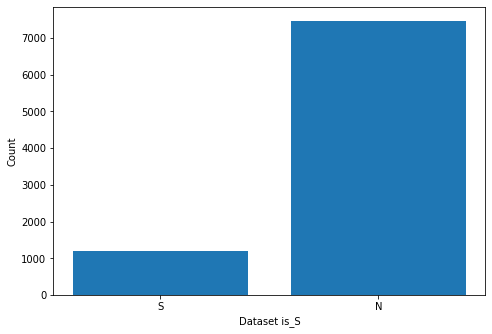

In [8]:
N, S = df_data_NS['is_S'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['S', 'N']
students = [S, N]
ax.bar(langs,students)
ax.set_xlabel('Dataset is_S')
ax.set_ylabel('Count')
plt.show()

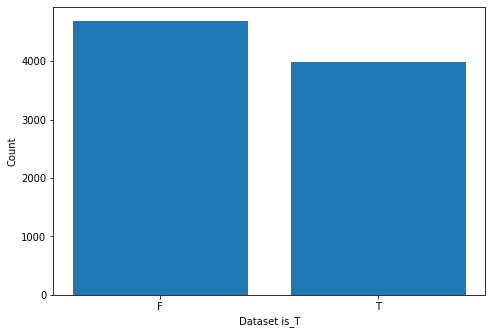

In [9]:
F, T = df_data_FT['is_T'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['F', 'T']
students = [F, T]
ax.bar(langs,students)
ax.set_xlabel('Dataset is_T')
ax.set_ylabel('Count')
plt.show()

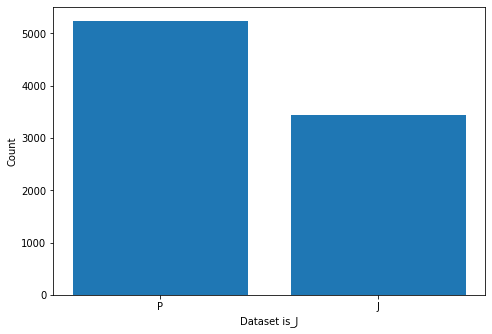

In [10]:
P, J = df_data_PJ['is_J'].value_counts()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['P', 'J']
students = [P, J]
ax.bar(langs,students)
ax.set_xlabel('Dataset is_J')
ax.set_ylabel('Count')
plt.show()

In [11]:
#Separating into training, validation and Testing data 60, 20, 20 - 5205, 1735 and 1735
train_IE, validate_IE, test_IE = np.split(df_data_IE.sample(frac=1, random_state=42), [int(.6*len(df_data_IE)), int(.8*len(df_data_IE))])
train_NS, validate_NS, test_NS = np.split(df_data_NS.sample(frac=1, random_state=42), [int(.6*len(df_data_NS)), int(.8*len(df_data_NS))])
train_FT, validate_FT, test_FT = np.split(df_data_FT.sample(frac=1, random_state=42), [int(.6*len(df_data_FT)), int(.8*len(df_data_FT))])
train_PJ, validate_PJ, test_PJ = np.split(df_data_PJ.sample(frac=1, random_state=42), [int(.6*len(df_data_PJ)), int(.8*len(df_data_PJ))])

#validate_IE   # to see the df if correct data is transfered

#Transfering to dataframe
#train_IE = pd.DataFrame(train_IE)
#validate_IE = pd.DataFrame(validate_IE)
#test_IE = pd.DataFrame(test_IE)

In [12]:
#Split the data to X and Y i.e. posts and labels
#For IE labels
X_train_IE = pd.DataFrame(train_IE['posts'])
Y_train_IE = pd.DataFrame(train_IE['is_E'])
X_validate_IE = pd.DataFrame(validate_IE['posts'])
Y_validate_IE = pd.DataFrame(validate_IE['is_E'])
X_test_IE = pd.DataFrame(test_IE['posts'])
Y_test_IE = pd.DataFrame(test_IE['is_E'])

#For IE labels
X_train_NS = pd.DataFrame(train_NS['posts'])
Y_train_NS = pd.DataFrame(train_NS['is_S'])
X_validate_NS = pd.DataFrame(validate_NS['posts'])
Y_validate_NS = pd.DataFrame(validate_NS['is_S'])
X_test_NS = pd.DataFrame(test_NS['posts'])
Y_test_NS = pd.DataFrame(test_NS['is_S'])

#For IE labels
X_train_FT = pd.DataFrame(train_FT['posts'])
Y_train_FT = pd.DataFrame(train_FT['is_T'])
X_validate_FT = pd.DataFrame(validate_FT['posts'])
Y_validate_FT = pd.DataFrame(validate_FT['is_T'])
X_test_FT = pd.DataFrame(test_FT['posts'])
Y_test_FT = pd.DataFrame(test_FT['is_T'])

#For IE labels
X_train_PJ = pd.DataFrame(train_PJ['posts'])
Y_train_PJ = pd.DataFrame(train_PJ['is_J'])
X_validate_PJ = pd.DataFrame(validate_PJ['posts'])
Y_validate_PJ = pd.DataFrame(validate_PJ['is_J'])
X_test_PJ = pd.DataFrame(test_PJ['posts'])
Y_test_PJ = pd.DataFrame(test_PJ['is_J'])

#display(Y_train_IE.iloc[1])

In [13]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

X_train_IE_clean = pd.DataFrame(X_train_IE.posts.apply(round1))
X_validate_IE_clean = pd.DataFrame(X_validate_IE.posts.apply(round1))
X_test_IE_clean = pd.DataFrame(X_test_IE.posts.apply(round1))

X_train_NS_clean = pd.DataFrame(X_train_NS.posts.apply(round1))
X_validate_NS_clean = pd.DataFrame(X_validate_NS.posts.apply(round1))
X_test_NS_clean = pd.DataFrame(X_test_NS.posts.apply(round1))

X_train_FT_clean = pd.DataFrame(X_train_FT.posts.apply(round1))
X_validate_FT_clean = pd.DataFrame(X_validate_FT.posts.apply(round1))
X_test_FT_clean = pd.DataFrame(X_test_FT.posts.apply(round1))

X_train_PJ_clean = pd.DataFrame(X_train_PJ.posts.apply(round1))
X_validate_PJ_clean = pd.DataFrame(X_validate_PJ.posts.apply(round1))
X_test_PJ_clean = pd.DataFrame(X_test_PJ.posts.apply(round1))

In [14]:
# Tokenization - this is taken from SpaCy  

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    tokens = re_tok.sub(r' \1 ', s).split()
    return tokens

# Defining lemmatization
wrl = WordNetLemmatizer()

In [15]:
#Remove stopword and also added the MBTI types to it
stop = set(stopwords.words('english'))
stop.update(['infp','infj','intp','intj','entp','enfp','istp','isfp','entj','istj','enfj','isfj','estp','esfp','esfj','estj'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

In [16]:
#Glove embedding loading
from tqdm import tqdm

embeddings_index_glove = {}
f = open('C:/Sujata/CompScience/Winter 2021/Data Mining/Project Final/glove.6B.300d.txt', encoding='utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except:
        continue
    embeddings_index_glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_glove))

400001it [00:38, 10524.30it/s]

Found 400001 word vectors.


In [17]:
def sent2vec(s, embeddings_index):
    words = str(s)
    words = tokenize(words)
    words = remove_stopwords(words)
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        w = wrl.lemmatize(w)
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [18]:
gc.collect()

# Create sentence vectors using the above function for training and validation set - this will convert the full sentence 
#into a vector 

xtrain_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_train_IE_clean['posts']]
xvalid_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_validate_IE_clean['posts']]
 
xtrain_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_train_FT_clean['posts']]
xvalid_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_validate_FT_clean['posts']]

xtrain_IE_glove = np.array(xtrain_IE_glove)
xvalid_IE_glove = np.array(xvalid_IE_glove)

xtrain_FT_glove = np.array(xtrain_FT_glove)
xvalid_FT_glove = np.array(xvalid_FT_glove)

 
# Generate Word vectors of test data is_E
xtest_IE_glove = [sent2vec(x, embeddings_index_glove) for x in X_test_IE_clean['posts']]
xtest_IE_glove = np.array(xtest_IE_glove)

# Generate Word vectors of test data is_T
xtest_FT_glove = [sent2vec(x, embeddings_index_glove) for x in X_test_FT_clean['posts']]
xtest_FT_glove = np.array(xtest_FT_glove)

print("xtest_IE_glove.shape = ", xtest_IE_glove.shape)
#xtrain_FT_glove

xtest_IE_glove.shape =  (1735, 300)


In [38]:
# SVM Done for is_E class
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='hinge', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_glove, Y_train_IE[class_name], cv=5, 
                                       scoring='recall'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_glove, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_glove, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.573109243697479
Validation score for class is_E is 0.7579250720461095


In [58]:
# SVM Done for is_T class
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = SGDClassifier(loss='hinge', max_iter=1000, epsilon=0.001, n_jobs=-1, class_weight='balanced')

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_glove, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_glove, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_glove, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.8170496770925662
Validation score for class is_T is 0.7671469740634006


In [46]:
# is_E logistic regression
col = ['is_E']
preds = np.zeros((X_validate_IE.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, xtrain_IE_glove, Y_train_IE[class_name], cv=5, 
                                       scoring='f1'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_IE_glove, Y_train_IE[class_name])
    
    val_score = classifier.score(xvalid_IE_glove, Y_validate_IE[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_E
CV score for class is_E is 0.5983193277310924
Validation score for class is_E is 0.6115273775216138


In [62]:
# is_T logistic regression
col = ['is_T']
preds = np.zeros((X_validate_FT.shape[0], len(col))).astype(object)

for i, class_name in enumerate(col):
    print('fit '+ class_name)
    classifier = LogisticRegression(C=0.1, solver='sag', class_weight='balanced', max_iter=1000)

    cv_score = np.mean(cross_val_score(classifier, xtrain_FT_glove, Y_train_FT[class_name], cv=5, scoring='roc_auc'))
    print('CV score for class {} is {}'.format(class_name, cv_score))

    classifier.fit(xtrain_FT_glove, Y_train_FT[class_name])
    
    val_score = classifier.score(xvalid_FT_glove, Y_validate_FT[class_name])
    print('Validation score for class {} is {}'.format(class_name, val_score))

fit is_T
CV score for class is_T is 0.7370950811982931
Validation score for class is_T is 0.6939481268011527


In [49]:
# is_E XGBoost Imbalanced data

def runXGB_U(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0  # look into it
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    param['scale_pos_weight'] = 0.3 # this says the distribution of the classes (total -ve classes/ total +ve classes)
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [65]:
# is_T XGBoost Balanced data

def runXGB_B(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=500):
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = 0.1
    param['max_depth'] = 6
    param['verbosity'] = 0  # look into it
    param['eval_metric'] = 'auc'
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'valid') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    return model

In [50]:
col = ['is_E']
preds = np.zeros((X_test_IE.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB_U(xtrain_IE_glove, Y_train_IE[j], xvalid_IE_glove, Y_validate_IE[j])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_IE_glove), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_E
[0]	train-error:0.21652	valid-error:0.23919
[1]	train-error:0.22632	valid-error:0.23170
[2]	train-error:0.22574	valid-error:0.23285
[3]	train-error:0.22747	valid-error:0.23228
[4]	train-error:0.22728	valid-error:0.23170
[5]	train-error:0.22690	valid-error:0.23228
[6]	train-error:0.22767	valid-error:0.23170
[7]	train-error:0.22709	valid-error:0.23112
[8]	train-error:0.22709	valid-error:0.23170
[9]	train-error:0.22670	valid-error:0.23170
[10]	train-error:0.22670	valid-error:0.23112
[11]	train-error:0.22594	valid-error:0.23112
[12]	train-error:0.22517	valid-error:0.23112
[13]	train-error:0.22459	valid-error:0.23055
[14]	train-error:0.22401	valid-error:0.23112
[15]	train-error:0.22459	valid-error:0.23055
[16]	train-error:0.22401	valid-error:0.23112
[17]	train-error:0.22286	valid-error:0.23228
[18]	train-error:0.22286	valid-error:0.23285
[19]	train-error:0.22286	valid-error:0.23228
[20]	train-error:0.22344	valid-error:0.23170
[21]	train-error:0.22267	valid-error:0.23228
[22]	train-

In [66]:
col = ['is_T']
preds = np.zeros((X_test_FT.shape[0], len(col)))

for i, j in enumerate(col):
    print('fit '+j)
    model = runXGB_B(xtrain_FT_glove, Y_train_FT[j], xvalid_FT_glove, Y_validate_FT[j])
    preds[:,i] = model.predict(xgb.DMatrix(xtest_FT_glove), ntree_limit = model.best_ntree_limit)
    gc.collect()

fit is_T
[0]	train-error:0.25572	valid-error:0.34236
[1]	train-error:0.22421	valid-error:0.32450
[2]	train-error:0.19808	valid-error:0.32161
[3]	train-error:0.18905	valid-error:0.30029
[4]	train-error:0.17887	valid-error:0.29452
[5]	train-error:0.17195	valid-error:0.28357
[6]	train-error:0.16868	valid-error:0.28012
[7]	train-error:0.15716	valid-error:0.28012
[8]	train-error:0.15255	valid-error:0.28415
[9]	train-error:0.14505	valid-error:0.27089
[10]	train-error:0.14063	valid-error:0.27262
[11]	train-error:0.13545	valid-error:0.26686
[12]	train-error:0.13314	valid-error:0.26628
[13]	train-error:0.12450	valid-error:0.27205
[14]	train-error:0.12142	valid-error:0.26801
[15]	train-error:0.11969	valid-error:0.26743
[16]	train-error:0.11066	valid-error:0.26513
[17]	train-error:0.10951	valid-error:0.26686
[18]	train-error:0.10490	valid-error:0.26225
[19]	train-error:0.10317	valid-error:0.26282
[20]	train-error:0.10029	valid-error:0.26167
[21]	train-error:0.09683	valid-error:0.25648
[22]	train-